# Import lib


In [1]:
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input,Dense,Flatten,Conv2D,BatchNormalization,MaxPooling2D,Dropout, Add
from tensorflow.keras.models import Model

# useful for getting number of output classes
from glob import glob

import matplotlib.pyplot as plt
from matplotlib import image
from PIL import Image

# Dataset

In [13]:
train_path = 'archive/colored_images_mod/train'
test_path = 'archive/colored_images_mod/test'

In [14]:
classes = glob('archive/colored_images_mod/train/*')

In [15]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 10,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [16]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 2929 images belonging to 5 classes.


In [17]:
test_set = test_datagen.flow_from_directory(test_path,
                                           target_size = (224, 224),
                                           batch_size = 64,
                                           class_mode = 'categorical')

Found 733 images belonging to 5 classes.


# Model 

In [2]:
# Define the model parameters using functional api

inputs = Input(shape=(224,224,3))
cnn1 = Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu')(inputs)
bnor1 = BatchNormalization()(cnn1)
max1 = MaxPooling2D(pool_size=(2,2))(bnor1)

cnn2 = Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same")(max1)
bnor2 = BatchNormalization()(cnn2)
max2 = MaxPooling2D(pool_size=(3,3))(bnor2)


cnn3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same")(max2)
bnor3 = BatchNormalization()(cnn3)

cnn4 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor3)
bnor4 = BatchNormalization()(cnn4)

cnn5 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor4)
add = Add()([cnn5,cnn3])
bnor5 = BatchNormalization()(add)

cnn6 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor5)
bnor6 = BatchNormalization()(cnn6)

cnn7 = Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same")(bnor6)
add1 = Add()([cnn7,bnor5])
bnor7 = BatchNormalization()(add1)
max3 = MaxPooling2D(pool_size=(2,2))(bnor7)

flat = Flatten()(max3)
dense1  = Dense(1024, activation = 'relu')(flat)
drop1 = Dropout(0.5)(dense1)
dense2 = Dense(1024, activation = 'relu')(drop1)
add2 = Add()([dense2,dense1])
dense3 = Dense(1024, activation = 'relu')(add2)
add3 = Add()([dense3,add2])
drop2 = Dropout(0.5)(add3)  # try once with this codeline and once withour it
outputs = Dense(5, activation = 'softmax')(drop2)

In [3]:
model = Model(inputs=inputs, outputs=outputs, name='UGP_model') # defining the model

In [4]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = Adam(learning_rate=0.001),
    metrics = ['accuracy']
)

model.summary()

Model: "UGP_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 54, 54, 128)  46592       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 54, 54, 128)  512         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 27, 27, 128)  0           batch_normalization[0][0]        
__________________________________________________________________________________________

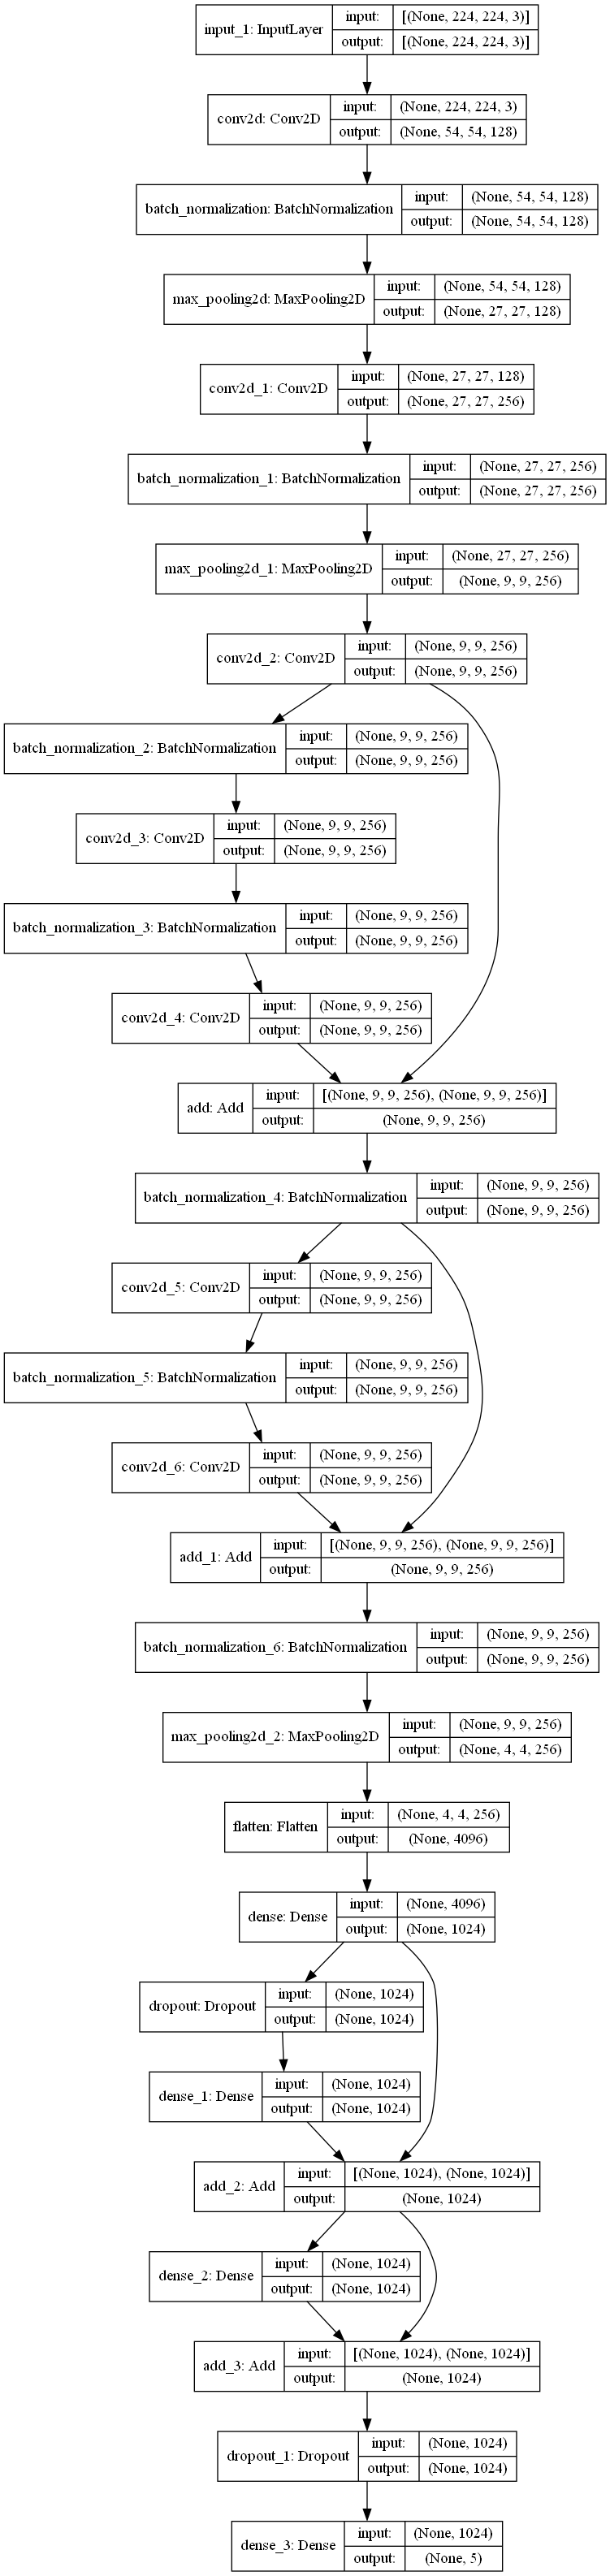

In [5]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,to_file='single.png')

In [22]:
r = model.fit(
    training_set,
    validation_data = test_set,
    epochs = 50,
    steps_per_epoch=len(training_set),
    validation_steps=len(test_set)
)

Epoch 1/50
46/46 [==============================] - 69s 1s/step - loss: 3.0703 - accuracy: 0.5196 - val_loss: 1.2462 - val_accuracy: 0.4952
Epoch 2/50
46/46 [==============================] - 28s 607ms/step - loss: 1.0411 - accuracy: 0.6244 - val_loss: 1.5548 - val_accuracy: 0.3274
Epoch 3/50
46/46 [==============================] - 29s 636ms/step - loss: 0.9427 - accuracy: 0.6688 - val_loss: 1.7512 - val_accuracy: 0.3015
Epoch 4/50
46/46 [==============================] - 29s 631ms/step - loss: 0.9150 - accuracy: 0.6828 - val_loss: 1.5463 - val_accuracy: 0.3206
Epoch 5/50
46/46 [==============================] - 29s 635ms/step - loss: 0.8727 - accuracy: 0.6914 - val_loss: 1.6559 - val_accuracy: 0.3847
Epoch 6/50
46/46 [==============================] - 30s 643ms/step - loss: 0.8624 - accuracy: 0.7037 - val_loss: 1.1722 - val_accuracy: 0.5744
Epoch 7/50
46/46 [==============================] - 30s 646ms/step - loss: 0.8637 - accuracy: 0.7006 - val_loss: 1.0541 - val_accuracy: 0.6412
Ep

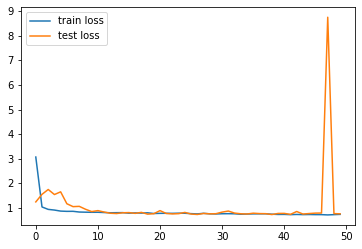

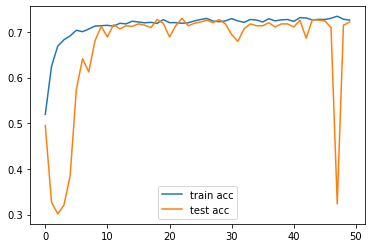

In [23]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()
plt.show()

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='test acc')
plt.legend()
plt.show()